In [1]:
import numpy as np
from itertools import product
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from mindreadingautobots.entropy_and_bayesian import boolean


This notebook searches for counterexamples to the conjecture that $s(f) \geq s(f_N^*)$

### Brute-force for $n \leq 4$
We are looking for a case where 
$$
s(f) < s(g^*)
$$
where $g^*$ is the maximum likelihood predictor for the noisy data $(Z, f(X))$. We will brute force search over _all_ boolean functions, which can be iterated since there is a one-to-one mapping between $F_n:=\{f: \{0,1\}^n \rightarrow \{0,1\}\}$ and $\{0,1\}^{2^n}$

In [ ]:
# n = 5


n = 4
assert n <= 4
k = n
# pvals = [0.01, 0.25, 0.49]
pvals = [0.49]

# a "signature" of a boolean function is a length 2**n bitstring S where f(x) = S[bin(x)]
sig_arr = np.array(list(itertools.product([0, 1], repeat=2 ** n)))
X_arr = np.array(list(itertools.product([0, 1], repeat=n)))
p_x = 1 / (2 ** k) # uniform distribution over x
for i, signature in enumerate(sig_arr):
    # iterate over signatures
    dct, func = boolean.boolean_function_from_signature(signature)
    for p in pvals:        
        # noisy_lookup[row,col] is the JOINT probability Pr(f(z)=row| x=col)
        noisy_lookup = np.zeros((2, 2**n))
        true_lookup = np.zeros((2, 2**n))
        # simulate a noisy dataset essentially
        for i, x in enumerate(product([0,1], repeat=k)):
            func_value = func(x)
            # true lookup is an array with 2 rows; there is a p_x at [row, column] if 
            # f[column] = row]. so, true_lookup[i, j] = pr(f(x) = i| x=j)
            true_lookup[func(x), i] = 1
            # iterate over all of the z values that contribute to 
            for e in product([0, 1], repeat=k):
                z = np.array(x) ^ np.array(e)
                p_x_given_z = p ** sum(e) * (1-p)**(k - sum(e))
                # increment noisy_lookup at the binary index of z
                # noisy_lookup[i, j] = pr(f(z) = i,  x=j) 
                noisy_lookup[func_value, int(''.join(map(str, z)), 2)] += p_x_given_z 
        
        # the function is balanced if the sums of the two rows of true_lookup are equal
        # imbal = abs(true_lookup[0,:].sum() - true_lookup[1,:].sum())  / 2 ** n
        # round up to get argmax 
        noisy_mle = np.round(noisy_lookup)  
        out = np.multiply(noisy_mle, true_lookup) / 2 ** n # "inner product" of the functions
        diff = out.sum()
        fnstar_dct = {}
        for i, x in enumerate(X_arr):
            fnstar_dct[tuple(x)] = np.argmax(noisy_lookup[:, i])
        def fnstar(x):
            return fnstar_dct[tuple(x)]
        
        # compute sensitivity at i of f and fnstar to check for unformity of bound?
        # for kk in range(n):
        #     sensitivity_i_f = boolean.average_s_i(func, kk, X_arr)
        #     sensitivity_i_fnstar = boolean.average_s_i(fnstar, kk, X_arr)
        #     if sensitivity_i_f < sensitivity_i_fnstar:
        #         sensitivity_i_f = boolean.average_s_i(func, kk, X_arr, verbose=True)
        #         sensitivity_i_fnstar = boolean.average_s_i(fnstar, kk, X_arr, verbose=True)
        #         print(f"ERROR: fn* has higher sensitivity than f at bit {kk}")
        #         print(true_lookup)
        #         print(noisy_mle)
        #         for k, v in dct.items():
        #             print(k, v)

        #         raise ValueError

        sensitivity_f = boolean.average_sensitivity(func, X_arr)
        sensitivity_fnstar = boolean.average_sensitivity(fnstar, X_arr)
        sensitivity_diff = sensitivity_f - sensitivity_fnstar
        # accuracies on dataset
        p_zy = boolean.generate_noisy_distr(k, p, func)
        noisy_f_acc = boolean.compute_acc_noisytest(p_zy, func, n) # accuracy of f on noisy data
        # noiseless_fnstar_acc = compute_acc_test(fnstar, func, n) # accuracy of fN* on noiseless data
        noisy_fnstar_acc = boolean.compute_acc_noisytest(p_zy, fnstar, n) # accuracy of fN* MLE on noisy data
        if sensitivity_f < sensitivity_fnstar:
            print("ERROR: fn* has lower sensitivity than f")
            raise ValueError


### Seaching for counterexamples to $f_N^* = f$ for parity and majority.

In [7]:
def majority_signature(n):
    assert n % 2 == 1
    halflength = n // 2

    return [0] * (halflength +1) + [1] * (halflength +1)

In [9]:
majority_signature(7)

[0, 0, 0, 0, 1, 1, 1, 1]

In [15]:
# n = 3 # total number of bits
p = 0.49# probability of each bit of X flipping, this DOESN'T flip Y ever.
# signature = [0, 1, 0, 1]


# signatures = [itertools.product([0, 1], repeat=n+1)]
# signatures = [signature]
signatures = [majority_signature(n) for n in [3, 5, 7, 9]]
for signature in signatures:
    n = len(signature) - 1
    X_arr = np.array(list(itertools.product([0, 1], repeat=n)))
    
    print("signature=", signature)
    hash = dict(zip(range(n+1), signature))
    func = lambda b: hash[sum(b)]

    f_accs = []
    fn_accs = []
    # noisy_lookup[row,col] is the JOINT probability Pr(f(z)=row| x=col)
    noisy_lookup = np.zeros((2, 2**n))
    true_lookup = np.zeros((2, 2**n))
    # simulate a noisy dataset essentially
    for i, x in enumerate(X_arr):
        func_value = func(x) # compute y=f(x)
        # true lookup is an array with 2 rows; there is a p_x at [row, column] if 
        # f[column] = row]. so, true_lookup[i, j] = pr(f(x) = i| x=j)
        true_lookup[func(x), i] = 1
        # iterate over all of the z values that contribute to 
        for e in product([0, 1], repeat=n):
            z = np.array(x) ^ np.array(e)
            p_x_given_z = p ** sum(e) * (1-p)**(n - sum(e))
            # increment noisy_lookup at the binary index of z
            # noisy_lookup[i, j] = pr(f(z) = i,  x=j) 
            noisy_lookup[func_value, int(''.join(map(str, z)), 2)] += p_x_given_z 

    # # round up to get argmax 
    noisy_mle = np.round(noisy_lookup)  
    print("noisy lookup table")
    print(noisy_mle)
    print("true lookup table")
    print(true_lookup)
    assert(np.all(noisy_mle == true_lookup))

    # print(noisy_mle)
    print()

    # # the function is balanced if the sums of the two rows of true_lookup are equal
    # # GOAL: f should not be too imbalanced <=> `imbal` should be close to 0
    # imbal = abs(true_lookup[0,:].sum() - true_lookup[1,:].sum())  / 2 ** n

    # # if not balanced:
    # #     continue
    # out = np.multiply(noisy_mle, true_lookup) / 2 ** n # "inner product" of the functions
    # diff = out.sum()


    # fnstar_dct = {}
    # for i, x in enumerate(X_arr):
    #     fnstar_dct[tuple(x)] = np.argmax(noisy_lookup[:, i])
    # def fnstar(x):
    #     return fnstar_dct[tuple(x)]

    # sensitivity_f = boolean.average_sensitivity(func, X_arr)
    # sensitivity_fnstar = boolean.average_sensitivity(fnstar, X_arr)
    # sensitivity_diff = sensitivity_f - sensitivity_fnstar
    # # accuracies on dataset
    # p_zy = boolean.generate_noisy_distr(n, p, func)
    # noisy_f_acc = boolean.compute_acc_noisytest(p_zy, func, n) # accuracy of f on noisy data
    # noiseless_fnstar_acc = boolean.compute_acc_test(fnstar, func, n) # accuracy of fN* on noiseless data
    # noisy_fnstar_acc = boolean.compute_acc_noisytest(p_zy, fnstar, n) # accuracy of fN* MLE on noisy data

    # acc_diff = noisy_fnstar_acc - noisy_f_acc
    # f_accs.append(noisy_f_acc)
    # fn_accs.append(noisy_fnstar_acc)

    # print("\t noisy fN* acc=", fn_accs)
    # print("\t noisy fN* sensitivity=", sensitivity_fnstar)

    # print("\t noisy f acc=", f_accs)
    # print("\t noisy f sensitivity=", sensitivity_f)

    # print((fn_accs[0], sensitivity_fnstar), (f_accs[0], sensitivity_f))
    # print()b


signature= [0, 0, 1, 1]
noisy lookup table
[[1. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 1.]]
true lookup table
[[1. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 1.]]

signature= [0, 0, 0, 1, 1, 1]
noisy lookup table
[[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1.
  0. 1. 1. 1. 1. 1. 1. 1.]]
true lookup table
[[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1.
  0. 1. 1. 1. 1. 1. 1. 1.]]

signature= [0, 0, 0, 0, 1, 1, 1, 1]
noisy lookup table
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
  1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0.
  1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0.
  1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  1

#### Looking for $\text{Pr}_{X|Z=z}(f(X) = f(z))$

This is to test our theory work on the majority function being optimal for noisy prediction. We compute (numerically) noisy majority performance, and compare it to an analytical formula.

In [33]:


# signatures = [itertools.product([0, 1], repeat=n+1)]
# signatures = [signature]
pvals = np.linspace(0.01, 0.5, 30)
signatures = [majority_signature(n) for n in [7]]
all_given_z = np.zeros((len(pvals), 2 ** 7))
for kk, p in enumerate(pvals):
    for signature in signatures:
        n = len(signature) - 1
        X_arr = np.array(list(itertools.product([0, 1], repeat=n)))
        hash = dict(zip(range(n+1), signature))
        func = lambda b: hash[sum(b)]

        f_accs = []
        fn_accs = []
        # noisy_lookup[row,col] is the JOINT probability Pr(f(z)=row| x=col)
        noisy_lookup = np.zeros((2, 2**n))
        true_lookup = np.zeros((2, 2**n))

        given_z = np.zeros(2**n)
        # simulate a noisy dataset essentially
        for i, x in enumerate(X_arr):
            func_value = func(x) # compute y=f(x)
            # true lookup is an array with 2 rows; there is a p_x at [row, column] if 
            # f[column] = row]. so, true_lookup[i, j] = pr(f(x) = i| x=j)
            true_lookup[func_value, i] = 1
            # iterate over all of the z values that contribute to 
            for e in product([0, 1], repeat=n):
                z = np.array(x) ^ np.array(e)
                p_x_given_z = p ** sum(e) * (1-p)**(n - sum(e))
                # increment noisy_lookup at the binary index of z
                # noisy_lookup[i, j] = pr(f(z) = i,  x=j) 
                z_idx = int(''.join(map(str, z)), 2)
                noisy_lookup[func_value, z_idx] += p_x_given_z 

                f_z = func(z)
                if f_z == func_value:
                    given_z[z_idx] += p_x_given_z
        all_given_z[kk] = given_z


        # # # round up to get argmax 
        # noisy_mle = np.round(noisy_lookup)  
        # print("noisy lookup table")
        # print(noisy_mle)
        # print("true lookup table")
        # print(true_lookup)
        # assert(np.all(noisy_mle == true_lookup))

        # # print(noisy_mle)
        # print()


In [61]:
from math import comb
def maj_ana(n, wt_z, p):
    """Compute Pr_{X|Z=z}(maj(X)=maj(z)) given wt(z)."""
    out = 0
    for w1 in range(0, wt_z + 1):
        pr1 = comb(wt_z, w1)
        for w0 in range(0, n//2 -wt_z + w1 + 1):
            pr2 = comb(n - wt_z, w0)
            err_wt = w0 + w1
            err_prob = p**(err_wt) * (1-p) **(n - err_wt)
            out += pr1 * pr2 * err_prob
    return out

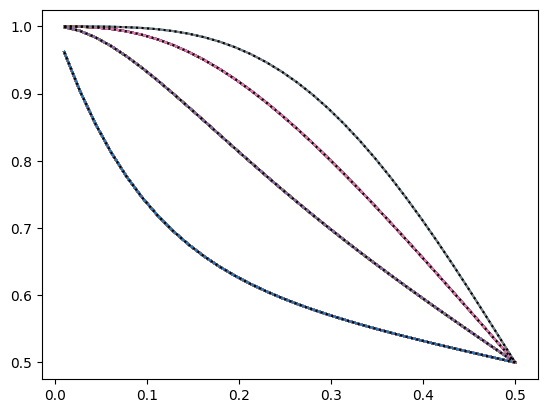

In [67]:
for i in range(2 ** 7):
    plt.plot(pvals, all_given_z[:,i])

for w in [0, 1, 2, 3]:
    y = [maj_ana(7, w, p) for p in pvals]
    plt.plot(pvals, y, ls=':', c='k')


This is some work checking theory for PARITY, i.e. showing that even bitflips are marginally more likely than odd ones.

In [72]:
def err_prob(n, wt_error, p):
    return p ** wt_error * (1-p)**(n - wt_error)

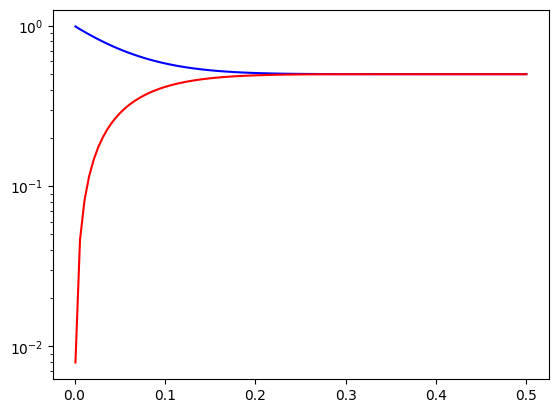

In [26]:

flip_probs = []
noflip_probs = []   
pvals = np.linspace(0.001, 0.4999, 100)
n = 8
for p in pvals:
    p_noflip = 0
    for k in range(0, n+1, 2): # even flip ratees
        p_noflip += (1-p)**(n-k) * p**k * comb(n, k)
    assert np.isclose(p_noflip, 0.5 + 0.5 * (1-2*p)**n)
    p_flip = 0
    for k in range(1, n+1, 2): # odd flip rates
        p_flip += (1-p)**(n-k) * p**k * comb(n, k)
    flip_probs.append(p_flip)
    noflip_probs.append(p_noflip)
plt.plot(pvals, noflip_probs, c='blue')
plt.plot(pvals, flip_probs, c='red')
plt.semilogy()
plt.show()



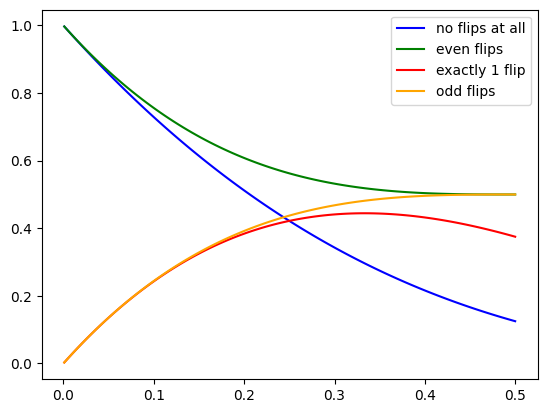

In [27]:
from math import comb
flip_probs = []
noflip_probs = []   
pvals = np.linspace(0.001, 0.4999, 100)
n = 3
p_noflip_0_arr = []
p_noflip_2_arr = []
p_flip_1_arr = []
p_flip_3_arr = []
for p in pvals:
    p_noflip_0 = (1-p)**(n) # probability of no flip
    p_noflip_2 = 3 * (1-p)**(n-2) * p**2 # probability of 2 flips
    p_flip_1 = 3 * (1-p)**(n-1) * p # probability of 1 flip
    p_flip_3 = p**3 # probability of 3 flips
    
    p_noflip_0_arr.append(p_noflip_0)
    p_noflip_2_arr.append(p_noflip_2 + p_noflip_0)
    p_flip_1_arr.append(p_flip_1)
    p_flip_3_arr.append(p_flip_3 + p_flip_1)


plt.plot(pvals, p_noflip_0_arr, c='blue', label='no flips at all')
plt.plot(pvals, p_noflip_2_arr, c='green', label='even flips')
plt.plot(pvals, p_flip_1_arr, c='red', label='exactly 1 flip')
plt.plot(pvals, p_flip_3_arr, c='orange', label='odd flips')

# plt.semilogy()
plt.legend()
plt.show()


#### Searching for counterexamples

Instead of defining boolean functions as $f:\{0,1\}^n \rightarrow \{0,1\}$, we define $f$ such that 
$$
f(x) = g(\text{wt}(x))
$$
what this does is, there are only $2^{n+1}$ possible functions $g$, instead of $2^{2^n}$ possible functions $f$. For example, if $n=3$, then a possible $g$ is 
\begin{equation}
     \text{wt}(x) \rightarrow \begin{cases}
        0 \rightarrow 0 \\
        1 \rightarrow 1 \\
        2 \rightarrow 0 \\
        3 \rightarrow 1
    \end{cases}
\end{equation}